<a href="https://colab.research.google.com/github/ChihabEddine98/DL_course/blob/main/go_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical,plot_model
from keras import layers,regularizers

In [2]:
# Params 
PLANES = 21
MOVES = 361
N = 100000
DIM = 19


## Generate Dataaa

# Inputs 
input_data = np.random.randint(2,size=(N,DIM,DIM,PLANES)).astype('float32')

# Outputs 
policy_data = np.random.randint(MOVES,size=(N,1))
policy_data = to_categorical(policy_data)

value_data = np.random.randint(2,size=(N,1)).astype('float32')

# Model structure 
def GO_CNN():
    # Input 
    inp = keras.Input(shape=(DIM,DIM,PLANES),name='board')
    # Conv block
    x = layers.Conv2D(64,(3,3),padding='same',activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = layers.Conv2D(128,(5,5),padding='same',activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)

    # Outputs 
    policy_head = layers.Conv2D(1, 1, kernel_regularizer=regularizers.l2(0.0001))(x)
    policy_head = tf.nn.relu(policy_head)
    policy_head = layers.BatchNormalization()(policy_head)
    policy_head = layers.Dropout(0.4)(policy_head)
    policy_head = layers.Flatten()(policy_head)
    policy_head = layers.Dense(MOVES,'softmax', name='policy')(policy_head)

    value_head = layers.GlobalAveragePooling2D()(x)
    value_head = layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001))(value_head)
    value_head = tf.nn.relu(value_head)
    value_head = layers.BatchNormalization()(value_head)
    value_head = layers.Dropout(0.4)(value_head)
    value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

    model = keras.Model(inputs=inp, outputs=[policy_head, value_head])
    model.compile(optimizer='adam',
                  loss={'policy': 'categorical_crossentropy','value': 'mse'}, 
                  loss_weights=[1., 0.2]
                  )
    return model


def train(model):
  with tf.device('/device:GPU:0'):
      history = model.fit(input_data,{'policy': policy_data, 'value': value_data},
                          batch_size = 256,
                          epochs = 20,
                          verbose = 1,
                          validation_split = 0.1)
            
  return history.history



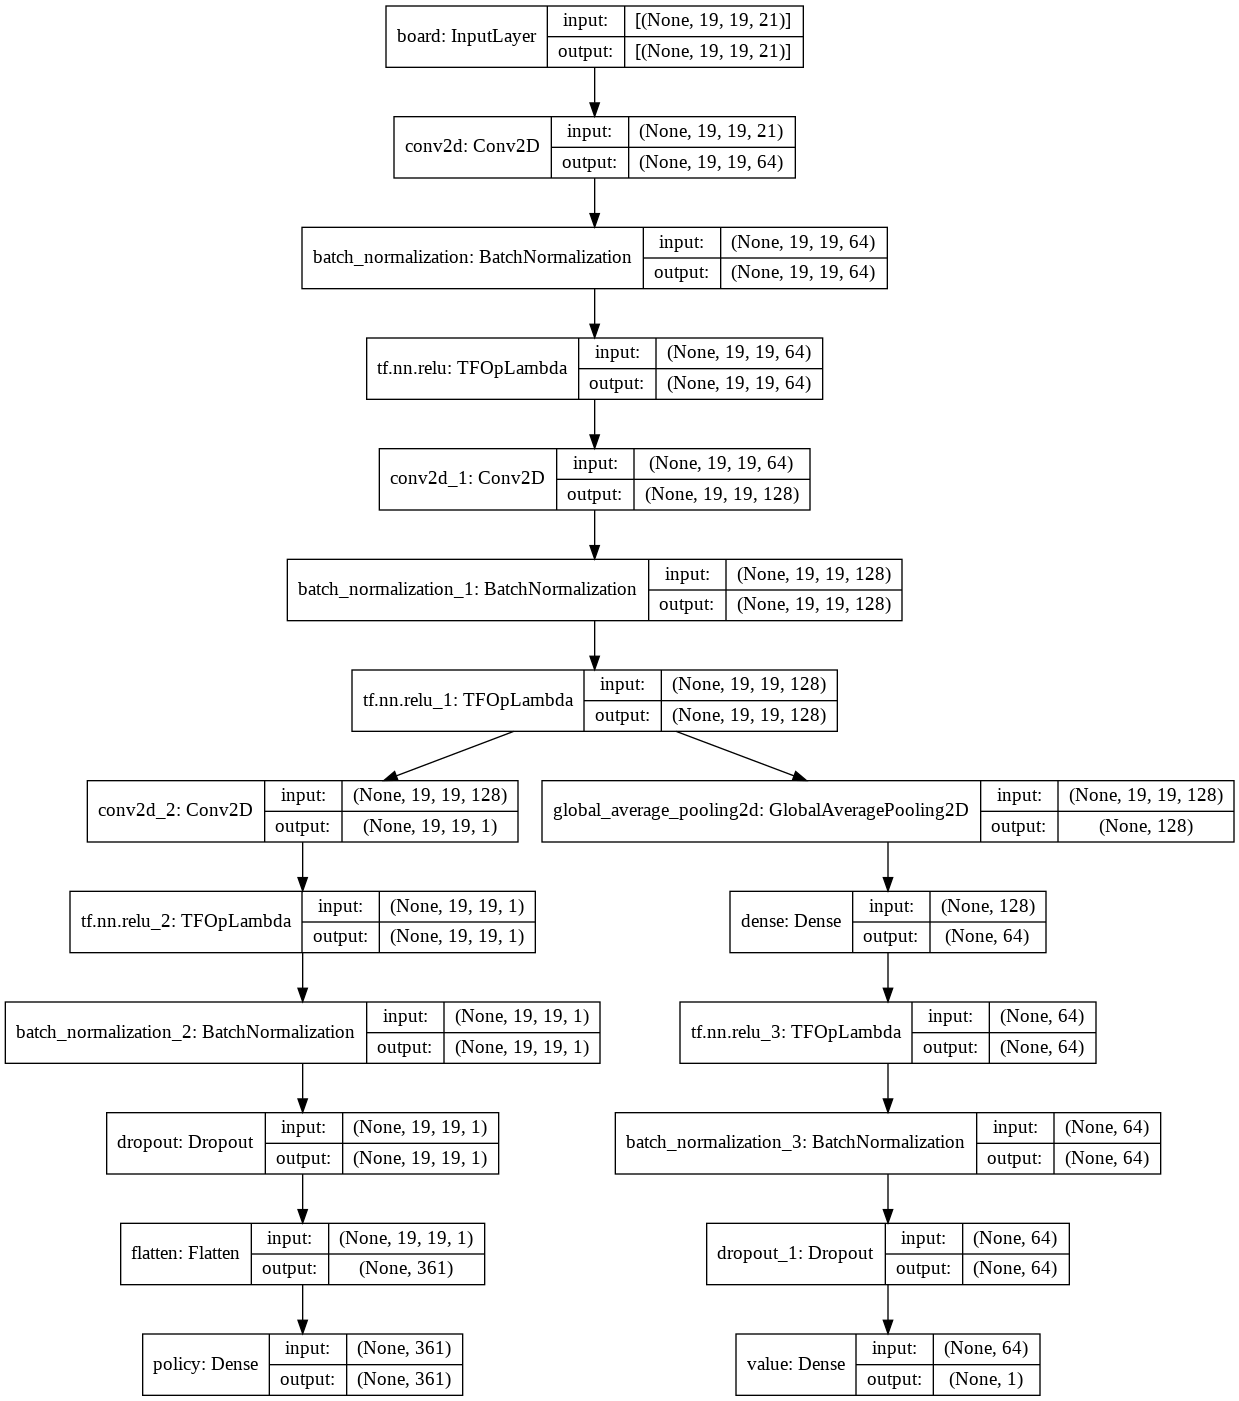

In [3]:
model = GO_CNN()
plot_model(model, 'multi_input_and_output_model_GO.png', show_shapes=True)

In [4]:
history = train(model)

Epoch 1/20
352/352 [==============================] - 29s 59ms/step - loss: 6.3041 - policy_loss: 6.2475 - value_loss: 0.2591 - val_loss: 6.0160 - val_policy_loss: 5.9630 - val_value_loss: 0.2503
Epoch 2/20
352/352 [==============================] - 20s 57ms/step - loss: 6.0026 - policy_loss: 5.9503 - value_loss: 0.2506 - val_loss: 5.9536 - val_policy_loss: 5.9018 - val_value_loss: 0.2512
Epoch 3/20
352/352 [==============================] - 20s 57ms/step - loss: 5.9477 - policy_loss: 5.8965 - value_loss: 0.2500 - val_loss: 5.9561 - val_policy_loss: 5.9043 - val_value_loss: 0.2549
Epoch 4/20
352/352 [==============================] - 20s 56ms/step - loss: 5.9066 - policy_loss: 5.8560 - value_loss: 0.2500 - val_loss: 5.9743 - val_policy_loss: 5.9236 - val_value_loss: 0.2510
Epoch 5/20
352/352 [==============================] - 20s 57ms/step - loss: 5.8476 - policy_loss: 5.7972 - value_loss: 0.2500 - val_loss: 6.0108 - val_policy_loss: 5.9603 - val_value_loss: 0.2506
Epoch 6/20
352/352 [

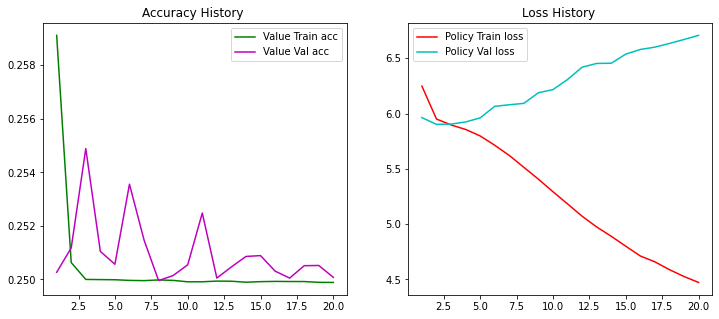

In [6]:
import matplotlib.pyplot as plt

def plots(epochs , history):
    fig,ax = plt.subplots(1,2)
    fig.set_size_inches((12,5))
    ax[0].plot(epochs, history['value_loss'] , 'g' , label = 'Value Train acc')
    ax[0].plot(epochs, history['val_value_loss'],'m',label = 'Value Val acc')
    ax[0].set_title('Accuracy History ')
    ax[0].legend()

    ax[1].plot(epochs, history['policy_loss'] , 'r',label = 'Policy Train loss')
    ax[1].plot(epochs, history['val_policy_loss'],'c',label = 'Policy Val loss')
    ax[1].set_title('Loss History ')
    ax[1].legend()

    fig.show()


epochs = range(1,21)
plots(epochs,history)